<a href="https://colab.research.google.com/github/afifahnisa17/machine_learning/blob/main/UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD DATA

In [ ]:
!pip install annoy faiss-cpu hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 26.5 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551811 sha256=c53f4b33a9bcc2f89a88619419530791933036bf21d3b236e7bf804f1f8f319c
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528146 sha256=e1883a30d9761bc4eb7b9f0196bbfc3e3c136fe2aee981d19e667b65ce599186
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built annoy hnswlib


In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/UCI_Credit_Card.csv')

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# PRE - PROCESSING DATA

# 1. Menangani Missing Values

In [ ]:
# Cek jumlah missing values per kolom
missing = df.isnull().sum()
print("Jumlah missing values per kolom:\n", missing)

# Total missing values di seluruh dataset
print("\nTotal missing values di dataset:", missing.sum())

Jumlah missing values per kolom:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Total missing values di dataset: 0


# 2. Standarisasi Data

In [54]:
# ======================
# MEMERIKSA NILAI UNIK DAN DUPLIKASI DATA
# ======================

import pandas as pd

# --- 1️⃣ Cek Nilai Unik di Kolom Penting ---
print("=== Mengecek Nilai Unik untuk Kolom Kategorikal dan Penting ===\n")

cols_check = ["ID", "SEX", "EDUCATION", "MARRIAGE"]

for col in cols_check:
    if col in df.columns:
        print(f"Kolom: {col}")
        print(f"Nilai unik: {df[col].unique()}")
        print("Frekuensi nilai:")
        print(df[col].value_counts().sort_index())
        print("-" * 60)

print("\nCatatan:")
print(" - Kolom SEX seharusnya hanya memiliki nilai {1, 2}")
print(" - Kolom EDUCATION biasanya bernilai {1, 2, 3, 4}")
print(" - Kolom MARRIAGE seharusnya bernilai {1, 2, 3}")
print("   Jika terdapat nilai 0 atau >4, maka terdapat data tidak valid.")
print("=" * 80)

# --- 2️⃣ Cek Baris Duplikat ---
print("\n=== Mengecek Duplikasi Baris ===\n")

total_rows = len(df)
unique_rows = df.drop_duplicates().shape[0]
duplicate_rows = total_rows - unique_rows

print(f"Total baris dalam dataset : {total_rows}")
print(f"Jumlah baris unik         : {unique_rows}")
print(f"Jumlah baris duplikat     : {duplicate_rows}")

if duplicate_rows > 0:
    print("\nTerdapat baris duplikat dalam dataset.")
    print("Gunakan perintah berikut untuk menghapusnya jika diperlukan:")
    print("   df = df.drop_duplicates().reset_index(drop=True)")
else:
    print("\nTidak ada baris duplikat. Semua data bersifat unik.")
print("=" * 80)

# --- 3️⃣ Cek Validitas Data Spesifik (Contoh: SEX) ---
print("\n=== Mengecek Validitas Nilai pada Kolom 'SEX' ===")

if "SEX" in df.columns:
    invalid_sex = df[~df["SEX"].isin([1, 2])]
    if not invalid_sex.empty:
        print(f"\nDitemukan {len(invalid_sex)} data dengan nilai tidak valid pada kolom 'SEX':")
        print(invalid_sex[["ID", "SEX"]].head())
        print("\nDisarankan untuk memperbaiki nilai-nilai tersebut.")
    else:
        print("\nSemua nilai pada kolom 'SEX' valid (1 = Laki-laki, 2 = Perempuan).")
print("=" * 80)


=== Mengecek Nilai Unik untuk Kolom Kategorikal dan Penting ===

Kolom: ID
Nilai unik: [    1     2     3 ... 29998 29999 30000]
Frekuensi nilai:
ID
1        1
2        1
3        1
4        1
5        1
        ..
29996    1
29997    1
29998    1
29999    1
30000    1
Name: count, Length: 30000, dtype: int64
------------------------------------------------------------
Kolom: SEX
Nilai unik: [2 1]
Frekuensi nilai:
SEX
1    11888
2    18112
Name: count, dtype: int64
------------------------------------------------------------
Kolom: EDUCATION
Nilai unik: [2 1 3 4]
Frekuensi nilai:
EDUCATION
1    10585
2    14030
3     4917
4      468
Name: count, dtype: int64
------------------------------------------------------------
Kolom: MARRIAGE
Nilai unik: [1 2 3]
Frekuensi nilai:
MARRIAGE
1    13659
2    15964
3      377
Name: count, dtype: int64
------------------------------------------------------------

Catatan:
 - Kolom SEX seharusnya hanya memiliki nilai {1, 2}
 - Kolom EDUCATION biasanya 

# 3. Menambahkan Fitur Baru

In [ ]:
# ===============================
# Buat fitur baru terlebih dahulu
# ===============================
df["TOTAL_PAY_AMT"] = df[[f"PAY_AMT{i}" for i in range(1,7)]].sum(axis=1)
df["TOTAL_BILL_AMT"] = df[[f"BILL_AMT{i}" for i in range(1,7)]].sum(axis=1)
df["PAY_RATIO"] = df["TOTAL_PAY_AMT"] / df["TOTAL_BILL_AMT"].replace(0, 1)

# ===============================
# Cek fitur baru
# ===============================
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,TOTAL_PAY_AMT,TOTAL_BILL_AMT,PAY_RATIO
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,689.0,0.0,0.0,0.0,0.0,1,689.0,7704.0,0.089434
1,2,120000.0,2,2,2,26,-1,2,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,5000.0,17077.0,0.292791
2,3,90000.0,2,2,2,34,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,11018.0,101653.0,0.108388
3,4,50000.0,2,2,1,37,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,8388.0,231334.0,0.036259
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,59049.0,109339.0,0.540054


In [ ]:
# ==============================
# 🔹 Siapkan fitur untuk clustering
# ===============================
X = df[["LIMIT_BAL", "AGE", "PAY_RATIO", "TOTAL_BILL_AMT"]]

# Kolom yang tidak perlu di-scale (biarkan dalam nilai asli)
keep_original = ["AGE", "LIMIT_BAL", "PAY_RATIO", "TOTAL_BILL_AMT"]

# Kolom lain akan di-scale
scale_cols = [col for col in X.columns if col not in keep_original]

scaler = StandardScaler()
if scale_cols:
    X[scale_cols] = scaler.fit_transform(X[scale_cols])

# ELBOW METHOD UNTUK MENENTUKAN JUMLAH CLUSTER OPTIMAL

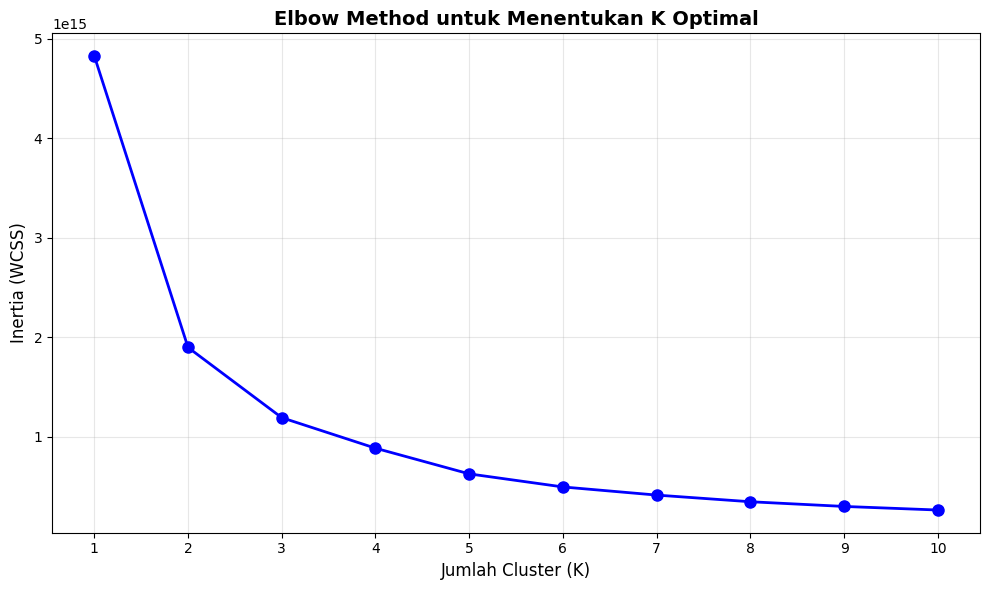

Inertia (WCSS) untuk setiap K:
K =  1 | Inertia = 4826992521381617.00
K =  2 | Inertia = 1897603790021911.25
K =  3 | Inertia = 1191889351273803.25
K =  4 | Inertia = 884978095618859.38
K =  5 | Inertia = 626930731917037.38
K =  6 | Inertia = 495545999707146.06
K =  7 | Inertia = 413760532468730.62
K =  8 | Inertia = 346834715216653.31
K =  9 | Inertia = 299662297149116.44
K = 10 | Inertia = 263606090325033.12


In [ ]:
# ===============================
# 🔹 Elbow Method
# ===============================
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X)
    inertias.append(kmeans_temp.inertia_)

# Visualisasi Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Jumlah Cluster (K)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.title('Elbow Method untuk Menentukan K Optimal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

# Cetak nilai inertia untuk setiap K
print("Inertia (WCSS) untuk setiap K:")
for k, inertia in zip(K_range, inertias):
    print(f"K = {k:2d} | Inertia = {inertia:.2f}")


# SILHUOTTE SCORE

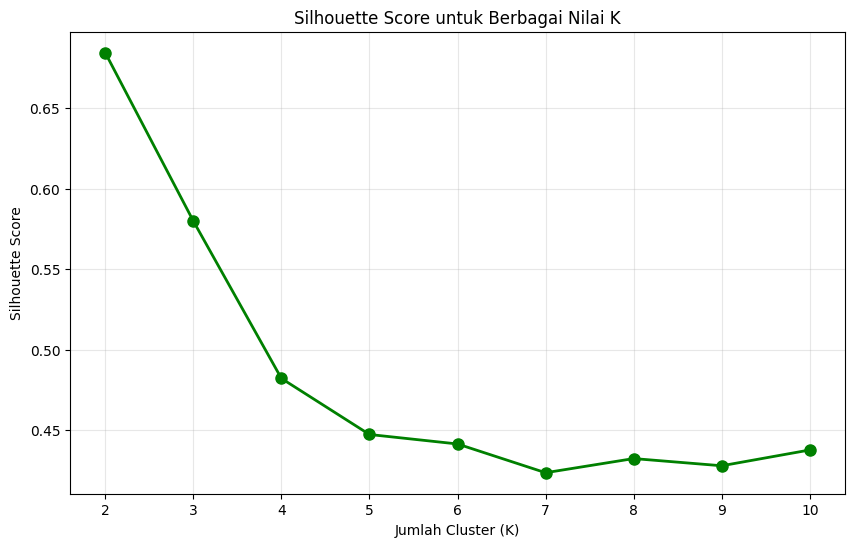


K optimal berdasarkan Silhouette Score: 2


In [ ]:
# ===============================
# 🔹 Silhouette Score
# ===============================
silhouette_scores = []
K_range_silhouette = range(2, 11)

for k in K_range_silhouette:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Berbagai Nilai K')
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = list(K_range_silhouette)[silhouette_scores.index(max(silhouette_scores))]
print(f"\nK optimal berdasarkan Silhouette Score: {optimal_k}")

# KMEANS DAN DBSCAN

In [ ]:
# --- Clustering ---
# KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X)

# Evaluasi
print("="*60)
print("HASIL CLUSTERING DENGAN DATA OPTIMASI")
print("="*60)
print(f"\nKMeans:")
print(f"Silhouette Score: {silhouette_score(X, labels_kmeans):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X, labels_kmeans):.4f}")

print(f"\nDBSCAN:")
print(f"Silhouette Score: {silhouette_score(X, labels_dbscan):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X, labels_dbscan):.4f}")
print("="*60)

HASIL CLUSTERING DENGAN DATA OPTIMASI

KMeans:
Silhouette Score: 0.6843
Davies-Bouldin Index: 0.5819

DBSCAN:
Silhouette Score: -0.4464
Davies-Bouldin Index: 1.0401


# VISUALISASI

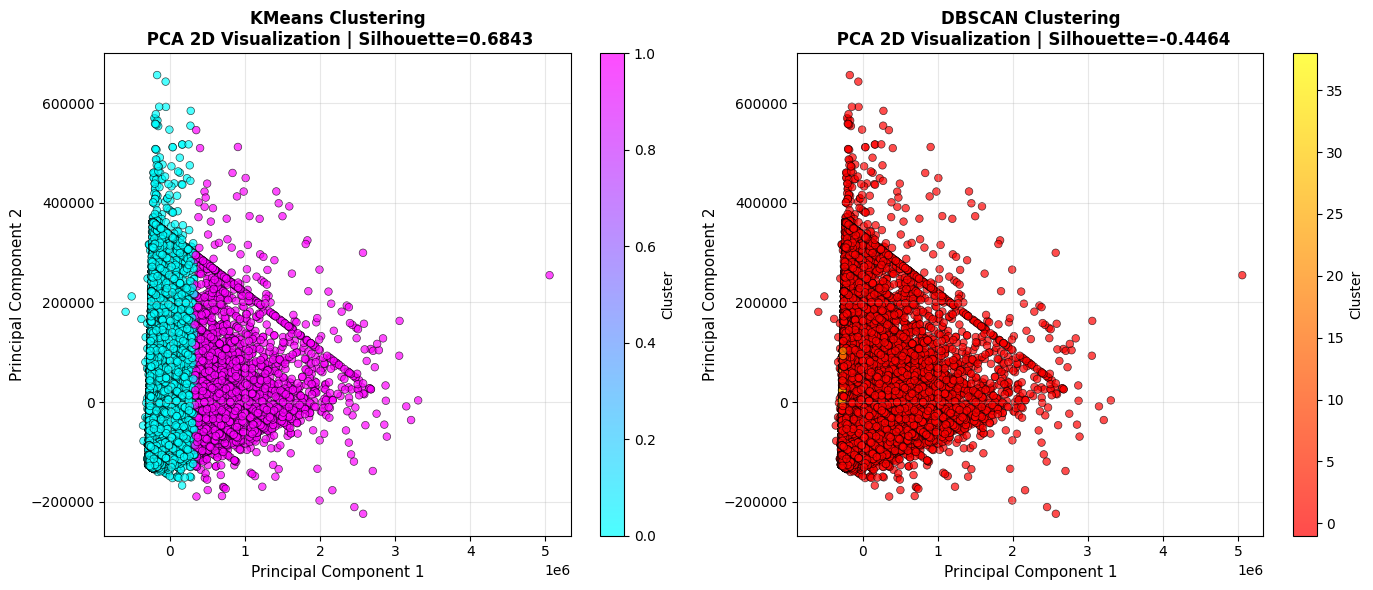

In [ ]:
# --- Visualisasi PCA 2D ---
# Gunakan X_cluster (data dengan fitur yang relevan)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot KMeans
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='cool', s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'KMeans Clustering\n PCA 2D Visualization | Silhouette={silhouette_score(X, labels_kmeans):.4f}',
                  fontweight='bold', fontsize=12)
axes[0].set_xlabel('Principal Component 1', fontsize=11)
axes[0].set_ylabel('Principal Component 2', fontsize=11)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot DBSCAN
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='autumn', s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'DBSCAN Clustering\n PCA 2D Visualization | Silhouette={silhouette_score(X, labels_dbscan):.4f}',
                  fontweight='bold', fontsize=12)
axes[1].set_xlabel('Principal Component 1', fontsize=11)
axes[1].set_ylabel('Principal Component 2', fontsize=11)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# ANNOY

In [ ]:
# --- ANN (Annoy) ---
# Gunakan X (data yang sudah distandarisasi)
import random
dim = X.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Bangun index Annoy
for i, v in enumerate(X.values):  # Use .values to iterate over the numpy array
    ann.add_item(i, v)
ann.build(10)

# Pilih 3 query points random
query_indices = random.sample(range(len(X)), 3)

for q in query_indices:
    neighbors = ann.get_nns_by_item(q, 5, include_distances=True)
    print(f"Query Point Index: {q}")
    for n, d in zip(neighbors[0], neighbors[1]):
        print(f"  Neighbor Index: {n} | Distance: {d:.4f} | Cluster(KMeans): {labels_kmeans[n]}")
    print("-"*50)

Query Point Index: 3702
  Neighbor Index: 3702 | Distance: 0.0000 | Cluster(KMeans): 0
  Neighbor Index: 235 | Distance: 136.1324 | Cluster(KMeans): 0
  Neighbor Index: 4663 | Distance: 446.0281 | Cluster(KMeans): 0
  Neighbor Index: 25754 | Distance: 490.0166 | Cluster(KMeans): 0
  Neighbor Index: 2056 | Distance: 500.0019 | Cluster(KMeans): 0
--------------------------------------------------
Query Point Index: 19723
  Neighbor Index: 19723 | Distance: 0.0000 | Cluster(KMeans): 1
  Neighbor Index: 6008 | Distance: 8679.0020 | Cluster(KMeans): 1
  Neighbor Index: 9321 | Distance: 10367.0049 | Cluster(KMeans): 1
  Neighbor Index: 22891 | Distance: 27653.0000 | Cluster(KMeans): 1
  Neighbor Index: 14093 | Distance: 28679.0000 | Cluster(KMeans): 1
--------------------------------------------------
Query Point Index: 17492
  Neighbor Index: 17492 | Distance: 0.0000 | Cluster(KMeans): 0
  Neighbor Index: 14857 | Distance: 2314.0034 | Cluster(KMeans): 0
  Neighbor Index: 24504 | Distance: 3

# Analisis Clustering Kapasitas Finansial Menggunakan K-Means, DBSCAN, dan ANNOY

## 1. **Deskripsi Dataset**
Dataset yang digunakan merupakan data Credit Card Client yang berisi semua informasi terkait riwayat kartu kredit klien.

Dataset terdiri dari 3000 baris dan 25 kolom. Saya ingin menggambarkan kapasitas finansial dan juga perilaku pembayaran nasabah. Sehingga saya memerlukan 4 kolom:
* LIMIT_BAL → limit saldo kartu kredit (sudah ada dalam dataset)
* AGE → usia nasabah (sudah ada dalam dataset)
* TOTAL_BILL_AMT → total tagihan dari 6 bulan terakhir (belum ada dalam dataset)
* PAY_RATIO → rasio antara total pembayaran terhadap total tagihan (belum ada dalam dataset)



## 2. **Tahapan Preprocessing**

a. Menghapus kolom tidak relevan (ID, default.payment.next.month).

b. Menghilangkan duplikasi data

c. Membuat fitur baru:

*   TOTAL_PAY_AMT = total seluruh pembayaran 6 bulan
*   TOTAL_BILL_AMT = total seluruh tagihan 6 bulan
*   PAY_RATIO = rasio pembayaran terhadap total tagihan


## 3. Penentuan Jumlah Cluster (Elbow & Silhouette)
📍 Elbow Method
Metode ini digunakan untuk melihat nilai inertia (WCSS) terhadap jumlah klaster (K).

Nilai inertia menurun tajam hingga K=2, kemudian melandai → menunjukkan titik siku di K=2.

📍 Silhouette Score

Digunakan untuk mengukur seberapa baik setiap data cocok dengan klasternya.
Nilai tertinggi diperoleh pada K=2, sehingga jumlah klaster optimal adalah 2.

# 4. Perbedaan hasil KMeans dan DBSCAN, mana yang lebih baik diantara kedua model

| **Aspek**             | **K-Means**                                                                                      | **DBSCAN**                                                                                   |
|------------------------|--------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Silhouette Score**   | ✅ Lebih tinggi (**0.6843**) → menunjukkan klaster yang lebih baik dan terpisah dengan jelas     | ❌ Negatif (**–0.4464**) → menandakan klaster buruk dan data tidak terbagi dengan baik        |
| **Struktur Visual**    | ✅ Terbentuk dua klaster yang jelas dan terpisah dalam visualisasi PCA                           | ❌ Hampir semua titik berada di area yang sama, sulit membedakan klaster                      |
| **Kelemahan**          | Harus menentukan jumlah klaster `k` terlebih dahulu                                              | Sensitif terhadap parameter `eps` dan `min_samples`, gagal jika data terlalu padat            |
| **Kelebihan**          | Stabil, mudah digunakan, cocok untuk data besar dan terstandarisasi seperti dataset ini          | Cocok untuk mendeteksi outlier dan klaster dengan bentuk tidak beraturan (bukan kasus ini)    |


Model K-Means lebih baik digunakan untuk dataset Credit Card Clients ini karena:

* Memberikan Silhouette Score yang lebih tinggi, menandakan kualitas klaster yang lebih baik.
* Hasil visual menunjukkan dua kelompok nasabah yang terpisah secara jelas berdasarkan limit saldo, usia, rasio pembayaran, dan total tagihan.

Sementara itu, DBSCAN kurang efektif karena data hanya membentuk 1 klaster besar.

Dengan demikian, K-Means lebih unggul dalam mengelompokkan nasabah berdasarkan kapasitas finansial pada dataset ini.


# 5. Nilai Metrik Terbaik

| Model   | Silhouette Score | Davies-Bouldin Index |
|----------|------------------|----------------------|
| **K-Means** | ✅ **0.6843** → menunjukkan kualitas klaster yang baik dan terpisah jelas | ✅ **0.5819** → semakin kecil nilainya, semakin baik pemisahan antar klaster |
| **DBSCAN**  | ❌ **–0.4464** → menandakan struktur klaster yang buruk | ❌ **1.0401** → menunjukkan pemisahan klaster yang tidak optimal |

Model **K-Means** memberikan hasil yang jauh lebih baik dibandingkan **DBSCAN**, karena memiliki *Silhouette Score* yang tinggi dan *Davies-Bouldin Index* yang rendah.  
Dengan demikian, **K-Means merupakan model terbaik untuk dataset ini.**



# 6. Hasil Query Annoy — Apakah tetangga termasuk cluster yang sama?

Hampir semua tetangga terdekat dari setiap query berada dalam cluster yang sama.

Artinya, Annoy berhasil menemukan titik-titik dengan kemiripan tinggi berdasarkan jarak Euclidean, yang konsisten dengan hasil clustering K-Means.

# 7. KESIMPULAN

* K-Means menghasilkan pembagian cluster yang baik yaitu 2 cluster.

* DBSCAN gagal membentuk cluster pada dataset ini karena hanya menghasilkan 1 cluster.

* Annoy mampu mengonfirmasi bahwa titik-titik dalam satu cluster memang memiliki kemiripan jarak yang tinggi.